<a href="https://colab.research.google.com/github/LouisLortie/colab/blob/main/ecse_551_assignment1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
#@title Import list

# from google.colab import drive                    # Need to activate this if using Google Colab (with drive)
import csv
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [21]:
#@title Load CSV

# drive.mount('/content/drive')                    # Activate on drive
# Reading air quality data
# aq_csv = pd.read_csv("/content/drive/MyDrive/ecse_551/assignment1/air_quality.csv")                 # Active on drive
aq_csv = pd.read_csv("air_quality.csv") 

# Reading liver patient data
# lp_csv = pd.read_csv("/content/drive/MyDrive/ecse_551/assignment1/liver_patient.csv")               # Active on drive
lp_csv = pd.read_csv("liver_patient.csv") 

# Array
aq_data = np.array(aq_csv)
lp_data = np.array(lp_csv)

In [121]:
#@title Setting rcParams
plt.style.use('classic')
plt.rcParams.update({
                        #  "text.usetex": True,
                        #  "font.family": "serif",
                        #  "font.sans-serif": ["Times"],
                         "lines.linewidth" : 3,
                         "font.size" : 12,
                         "figure.constrained_layout.use" : True,
                         "hist.bins" : 100 
                         })

11
(854, 11) 

(11,) 

(744, 11) 

(854, 11) 

(1598,)


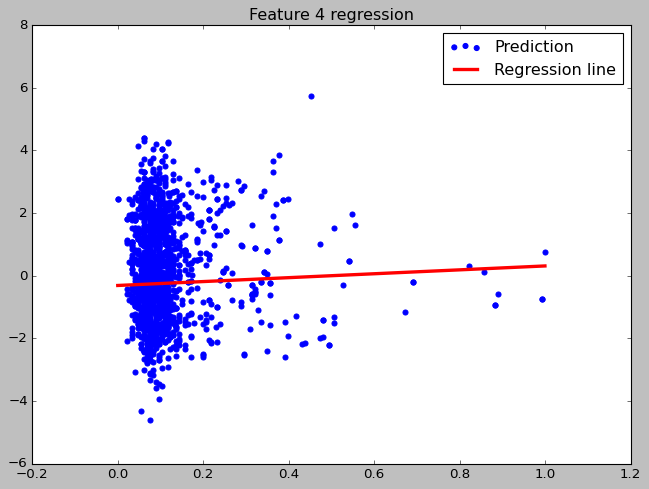

In [138]:
#@title Main function
def main():

  feat = 3   # Feature to analyse starting from 0
  
  # plot_hist(data_pos[:, feat], data_neg[:, feat], feat)
  
  model2 = GenerativeLearning(aq_data)

  plot_regression(model2.data[:,feat], model2.y, model2.w, feat)

  
  
if __name__ == '__main__':
    main()

In [141]:
#@title data_separation: Function that separates the training data into the two binary classes
def data_separation(data):

  count_pos = 0
  count_neg = 0
  
  for i in range(data.shape[0]) :      # all rows of data

    if data[i, -1] == 0 :
      if count_neg == 0 :
        data_neg = data[[i], :]
      else :
        data_neg = np.concatenate((data_neg, data[[i], :]), axis=0)
      count_neg += 1

    elif data[i, -1] == 1 :
      if count_pos == 0 :
        data_pos = data[[i], :]
      else :
        data_pos = np.concatenate((data_pos, data[[i], :]), axis=0)
      count_pos += 1

  return data_pos, data_neg

In [140]:
#@title feature_count: Function that counts the number of features
def feature_count(data):
  return data.shape[1] - 1         # The last column is the class label

In [139]:
#@title plot hist: Function that plots the histogram of one feature
# The number of bins can be changed via rcParams above.

def plot_hist(feat_pos, feat_neg, feat_num):
  fig, ax = plt.subplots(2, 1, sharex=True)
  ax[0].hist(feat_pos, color="b", label=r"Class y = 1")
  ax[1].hist(feat_neg, color="r", label=r"Class y = 0")
  ax[0].set_title("Feature %i distribution comparison between classes" %(feat_num + 1))
  ax[0].legend(loc='upper right')
  ax[1].legend(loc='upper right')
  plt.tight_layout

  return 0

In [106]:
#@title Generativelearning class: Generative model for binary classification

class GenerativeLearning:

  def __init__(self, data):
    self.data = data
    self.data_pos, self.data_neg = data_separation(data)
    self.feat_count = feature_count(self.data)
    self.pos_count = self.data_pos.shape[0]
    self.neg_count = self.data_neg.shape[0]
    self.pos_prior = self.pos_count / self.data.shape[0]
    self.neg_prior = self.neg_count / self.data.shape[0]
    self.pos_mean = np.mean(self.data_pos[:,:-1], axis=0)
    self.neg_mean = np.mean(self.data_neg[:,:-1], axis=0)
    # self.pos_cov = np.cov(self.data_pos, rowvar=False)
    # self.neg_cov = np.cov(self.data_neg, rowvar=False)
    print(self.data_pos[:,:-1].shape, "\n")
    print(self.pos_mean.shape, "\n")
    print(self.data_neg[:,:-1].shape, "\n")
    print((self.data_pos[:,:-1] - self.pos_mean).shape, "\n")
    self.cov = ((self.data_pos[:,:-1] - self.pos_mean).T @ (self.data_pos[:,:-1] - self.pos_mean) + (self.data_neg[:,:-1] - self.neg_mean).T @ (self.data_neg[:,:-1] - self.neg_mean)) / (self.pos_count + self.neg_count - 2)

#   def discriminant(self, x, y):
#     return np.log(self.pos_prior) - np.log(self.neg_prior) + 0.5 * (x - y).T @ np.linalg.inv(self.pos_cov - self.neg_cov) @ (x - y)
  
  # def covariance_common(self):

  #   # Need to add dummy feature to data
  #   # self.data_pos = np.concatenate((self.data_pos, np.ones((self.pos_count, 1))), axis=1)
  #   # self.data_neg = np.concatenate((self.data_neg, np.ones((self.neg_count, 1))), axis=1)

  #   self.cov = ((self.data_pos - self.pos_mean).T @ (self.data_pos - self.pos_mean) + (self.data_neg - self.neg_mean).T @ (self.data_neg - self.neg_mean)) / (self.pos_count + self.neg_count - 2)  # remove last bracket and check copilot suggestion
  #   # Can we use np.linalg.inv()? Built in function and not effective.
    
  #   return 

#   def predict(self, x):
#     return self.discriminant(x, self.pos_mean) - self.discriminant(x, self.neg_mean)

  def fit(self):
    self.w0 = np.log(self.pos_prior) - np.log(self.neg_prior) - 0.5 * self.pos_mean .T @ np.linalg.inv(self.cov) @ self.pos_mean + 0.5 * self.neg_mean .T @ np.linalg.inv(self.cov) @ self.neg_mean
    self.w1 = np.linalg.inv(self.cov) @ (self.pos_mean - self.neg_mean)
    self.w = np.concatenate((self.w0.reshape(1,), self.w1))
    
    return self.w

  def predict(self, x):
    self.y = x @ self.w[1:] + self.w[0]
    return self.y

#   def plot(self):
#     fig, ax = plt.subplots(1, 1)
#     ax.scatter(self.data_pos[:, 0], self.data_pos[:, 1], color="b", label=r"Class y = 1")
#     ax.scatter(self.data_neg[:, 0], self.data_neg[:, 1], color="r", label=r"Class y = 0")
#     ax.set_title("Feature %i distribution comparison between classes" %(feat_num + 1))
#     ax.legend(loc='upper right')
#     plt.tight_layout

    return 0


In [137]:
#@title plot_regression: Function that plots the regression line

def plot_regression(x, y, w, feature_num):    # Where x is the domain to which the regression line is to be plotted and i the feature number
    
    range = np.arange(np.min(x), np.max(x), 1/y.shape[0])
    
    fig, ax = plt.subplots(1, 1)
    ax.scatter(x, y, color="b", label=r"Prediction")
    ax.plot(range, w[feature_num+1] * range + w[0], color="r", label=r"Regression line")    # Because w[0] is the bias term
    ax.set_title("Feature %i regression" %(feature_num + 1))
    ax.legend(loc='upper right')
    plt.tight_layout
    
    return 0